In [8]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

import pink_utils as pu
import pandas as pd
import numpy as np

In [9]:
hm = pu.heatmap('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images_EDMatrix.bin')
images = pu.image_binary('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images.bin')

In [10]:
df = pd.read_csv('../Experiment/Experiment_F3W2_95_5/Test_Images/RGZ_Test_Images_Dataframe.csv')

In [11]:
df.shape

(7464, 78)

In [12]:
images.file_head

(7464, 2, 167, 167)

In [13]:
hm.file_head

(7464, 15, 15, 1)

In [14]:
print('Loading the heatmaps')
maps = [hm.ed(index=i, prob=True) for i in range(hm.file_head[0])]

print('Loading the FIRST pre-processed images')
first = [images.get_image(index=i, channel=0) for i in range(hm.file_head[0])]

print('Loading the WISE pre-processed images')
wise = [images.get_image(index=i, channel=1) for i in range(hm.file_head[0])]

Loading the heatmaps
Loading the FIRST pre-processed images
Loading the WISE pre-processed images


In [15]:
import matplotlib.pyplot as plt

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


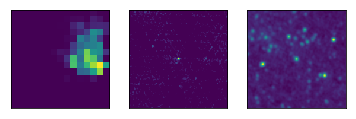

In [16]:
def no_ticks(ax):
    '''Disable ticks
    '''
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(1,3)
c = 103
for a in ax:
    no_ticks(a)

ax[0].imshow(maps[c])
ax[1].imshow(first[c])
ax[2].imshow(wise[c])

fig.show()

In [17]:
from collections import defaultdict

In [18]:
book = defaultdict(list)

for c, row in df.iterrows():
    label = row['label'].replace('_','\_')
    book[row['label']].append(maps[c])

In [19]:
som = pu.som('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5/F3W2S_95_5_6_19.bin')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


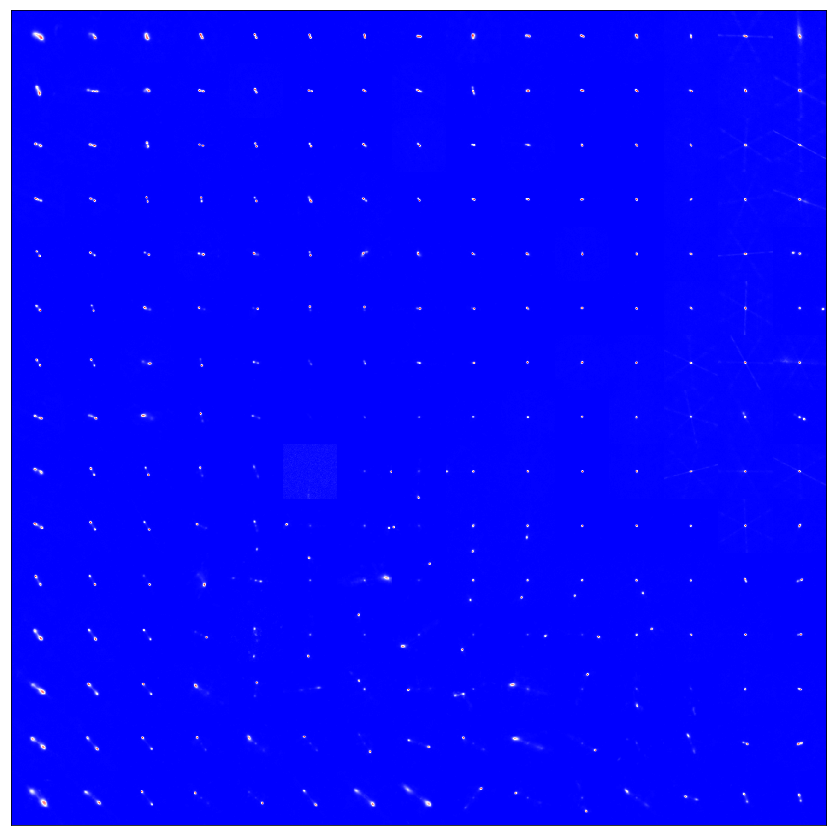

In [20]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=0), cmap='bwr')
no_ticks(ax)

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


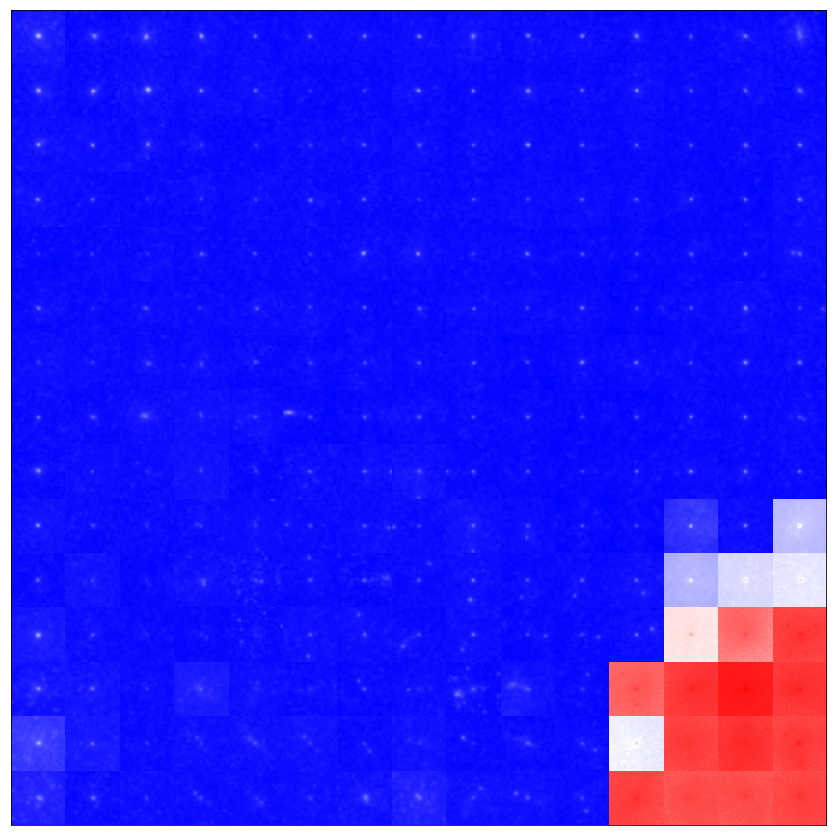

In [21]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=1), cmap='bwr')
no_ticks(ax)

fig.show()

In [22]:
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn import cross_validation

/Users/gal16b/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
np.random.seed(7464)
index = np.random.permutation(len(maps))

labels = df['label']
num_comp  = np.array([int(i.split('_')[0]) for i in labels])[index]
num_peaks = np.array([int(i.split('_')[1]) for i in labels])[index]

heatmaps  = np.array(maps).reshape(-1,15*15)[index]
total = heatmaps.shape[0]

suf_df = df.iloc[index]
a = []

for count, (i, row) in enumerate(suf_df.iterrows()):
    a.append(np.append(heatmaps[count], row['consensus.radio_level']))

heatmaps = np.array(a)
heatmaps.shape

(7464, 226)

In [24]:
n_estimators = 64*2 # how many trees, should be 256
cores = 8 # number of cpu cores to speed it up

peaks_rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=cores, bootstrap=True)
comp_rf  = RandomForestRegressor(n_estimators=n_estimators, n_jobs=cores, bootstrap=True)

peaks_res = cross_validation.cross_val_predict(peaks_rf, heatmaps, num_peaks, cv=5, n_jobs=-1)
comp_res = cross_validation.cross_val_predict(comp_rf, heatmaps, num_comp, cv=5, n_jobs=-1)


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


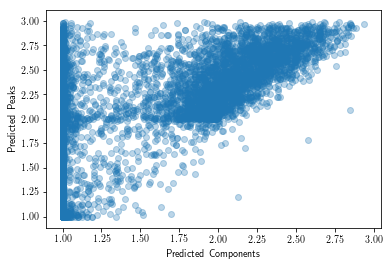

In [25]:
fig, ax = plt.subplots(1,1)

ax.scatter(comp_res, peaks_res, alpha=0.3)

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


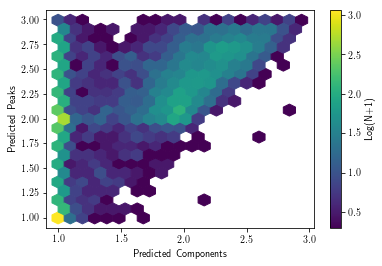

In [26]:
fig, ax = plt.subplots(1,1)

hb = ax.hexbin(comp_res, peaks_res, 
               bins='log', gridsize=20, mincnt=1)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Log(N+1)')

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()
# fig.savefig('Images/Predicted_Features_Heatmap.pdf')

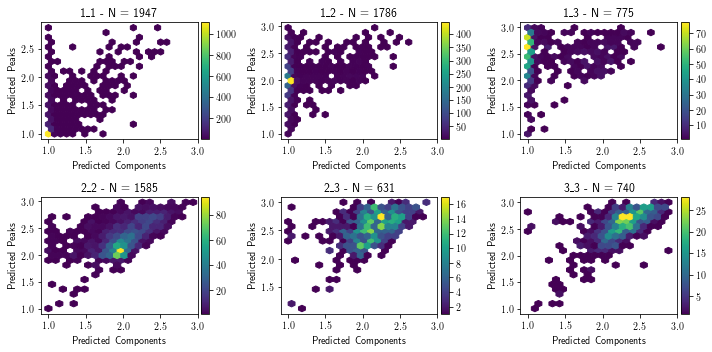

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def subplot_cbar(fig, ax, im):
        divider = make_axes_locatable(ax)
        cax0 = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax0)
    

fig, axes = plt.subplots(2,3, figsize=(10, 5))

for c, l in enumerate(np.sort(labels[index].unique())):
    mask = l == labels[index]
    t_l = l.replace('_','\_')
    ax = axes.flatten()[c]
    im = ax.hexbin(comp_res[mask], peaks_res[mask], gridsize=20, mincnt=1)
    ax.set(title=f'{t_l} - N = {np.sum(mask)}', xlim=[0.9,3],
          xlabel='Predicted Components',
          ylabel='Predicted Peaks')
    
    subplot_cbar(fig, ax, im)
    
fig.tight_layout()
# fig.show()
fig.savefig('Images/Figure_Predicted_Features_Heatmap_ClassesCL_Trained_CL_Feature.pdf')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


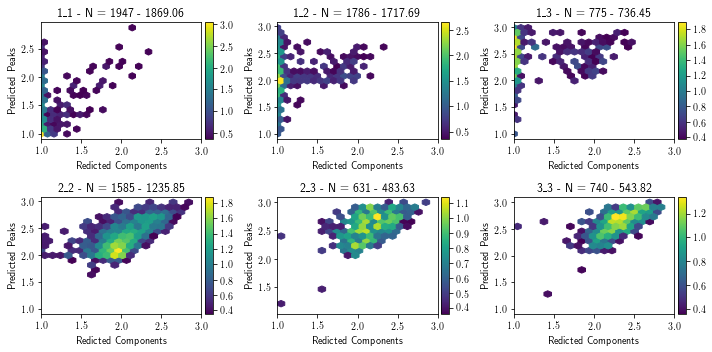

In [28]:

fig, axes = plt.subplots(2,3, figsize=(10, 5))

for c, l in enumerate(np.sort(labels[index].unique())):
    mask = l == labels[index]
    t_l = l.replace('_','\_')
    rcl_sum = np.sum(suf_df['consensus.radio_level'][mask])
    
    ax = axes.flatten()[c]
    im = ax.hexbin(comp_res[mask], peaks_res[mask], gridsize=20, bins='log', mincnt=1,
                  C=suf_df['consensus.radio_level'][mask],
                  reduce_C_function=np.sum)
    ax.set(title=f'{t_l} - N = {np.sum(mask)} - {rcl_sum:.2f}', xlim=[1,3],
          xlabel='Redicted Components',
          ylabel='Predicted Peaks')
    
    subplot_cbar(fig, ax, im)
    
fig.tight_layout()
fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


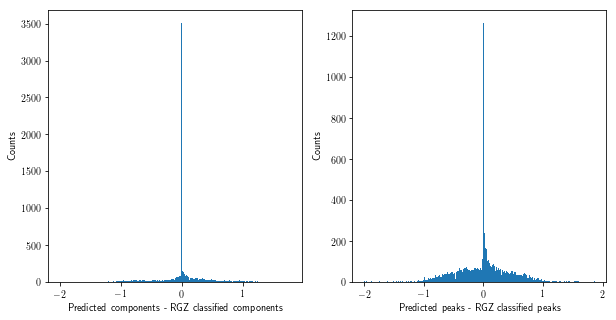

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist( comp_res - num_comp, bins=250 )
ax1.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

ax2.hist( peaks_res - num_peaks, bins=250 )
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

# 
fig.show()
# fig.savefig('Images/Predicted_Featurs_Histogram.pdf')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


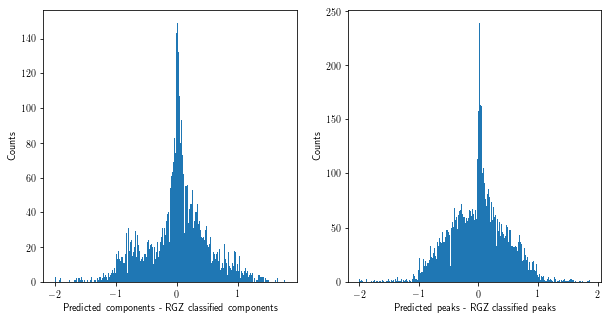

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

val = comp_res - num_comp
ax1.hist( val[val!=0], bins=250 )
ax1.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

val = peaks_res - num_peaks
ax2.hist(val[val != 0], bins=250 )
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')


fig.show()
# fig.savefig('Images/Predicted_Featurs_Histogram_No_Zero.pdf')

0.6-0.7
0.7-0.8
0.8-0.9
0.9-1.0


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


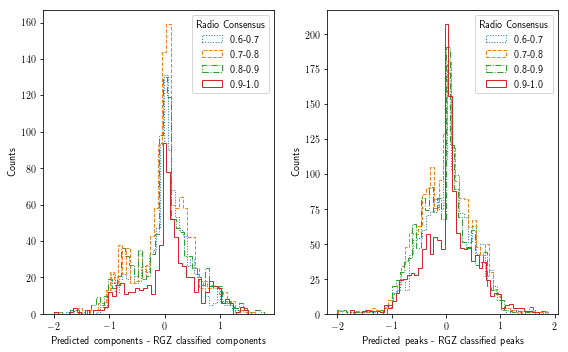

In [31]:
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

for c, b in enumerate(np.sort(bin_df.unique())):
    print(b)
    mask = b == bin_df
    
    val = comp_res - num_comp
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
    
    val = peaks_res - num_peaks
    ax2.hist(val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
fig.show()



0.6-0.7
0.7-0.8
0.8-0.9
0.9-1.0


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


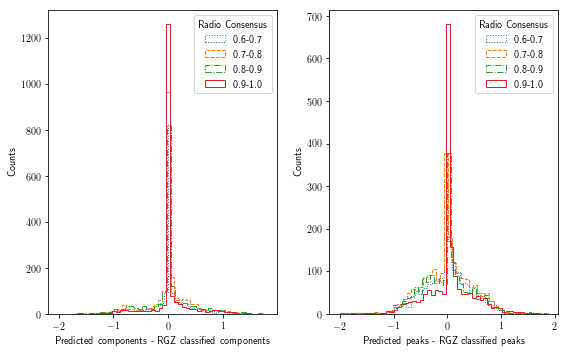

In [32]:
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

for c, b in enumerate(np.sort(bin_df.unique())):
    print(b)
    mask = b == bin_df
    
    val = comp_res - num_comp
    ax1.hist( val[mask], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
    
    val = peaks_res - num_peaks
    ax2.hist(val[mask], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
fig.show()


0.9-1.0
0.8-0.9
0.7-0.8
0.6-0.7


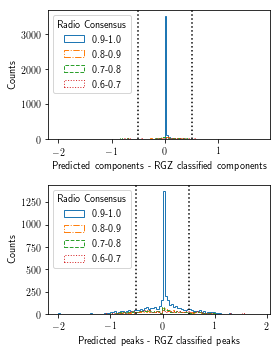

In [41]:
bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(4,5))
linestyles = [':','--','-.','-'][::-1]

for c, b in enumerate(np.sort(bin_df.unique())[::-1]):
    print(b)
    mask = b == bin_df
    
    val = comp_res - num_comp
    ax1.hist( val[mask], bins=100, label=f'{b}', histtype='step', linestyle=linestyles[c])
    
    val = peaks_res - num_peaks
    ax2.hist(val[mask], bins=100, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.axvline(-0.5, linestyle=':', color='black')
ax1.axvline(0.5, linestyle=':', color='black')

ax2.axvline(-0.5, linestyle=':', color='black')
ax2.axvline(0.5, linestyle=':', color='black')


ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
# fig.show()
fig.savefig('Images/Figure_MSE_Histogram_CL_Trained_CL_Feature.pdf')

In [40]:
val_comp = comp_res - num_comp
val_peaks = peaks_res - num_peaks

mask_comp = (val_comp >= -0.5) & (val_comp < 0.5)
mask_peaks = (val_peaks > -0.5) & (val_peaks < 0.5)

print(np.sum(mask_comp)/len(val_comp))
print(np.sum(np.abs(val_comp[mask_comp])))
print(np.sum(mask_peaks)/len(val_comp))
print(np.sum(np.abs(val_peaks[mask_peaks])))


0.83078778135
497.03125
0.741559485531
899.309505208


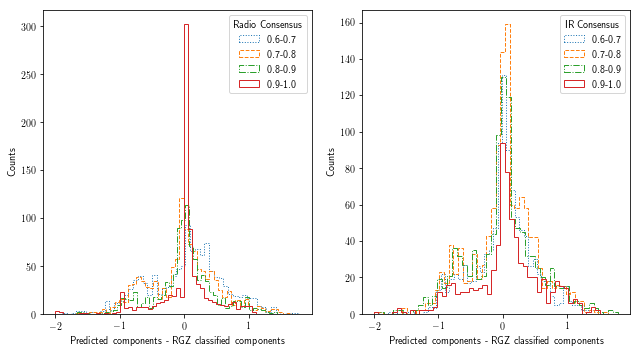

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,5))
linestyles = [':','--','-.','-']

val = comp_res - num_comp

bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

    
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax2.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='IR Consensus')
fig.tight_layout()
# fig.show()
fig.savefig('Images/Components_Histogram_Consensus.pdf')


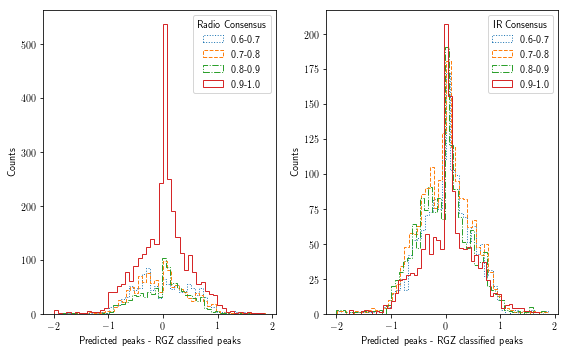

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

val = peaks_res - num_peaks

bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

    
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax2.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted peaks - RGZ classified peaks',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='IR Consensus')
fig.tight_layout()
# fig.show()
fig.savefig('Images/Peaks_Histogram_Consensus.pdf')

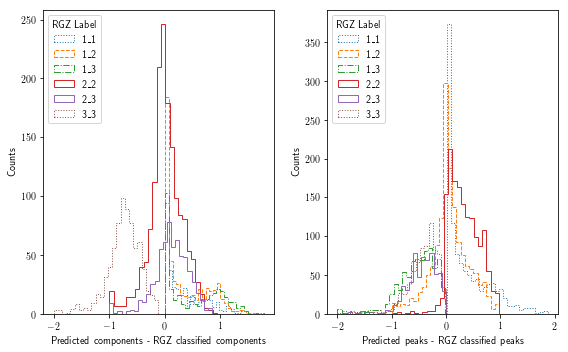

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-', '-',':']

val = comp_res - num_comp

bin_df = np.unique(suf_df['label'])
for c, b in enumerate(np.sort(bin_df)):
    t_b = b.replace('_','\_')
    mask = b ==  suf_df['label']   
    ax1.hist( val[(mask)&(val!=0)], bins=25, label=f'{t_b}', histtype='step', linestyle=linestyles[c])


val = peaks_res - num_peaks


bin_df = np.unique(suf_df['label'])
for c, b in enumerate(np.sort(bin_df)):
    mask = b == suf_df['label']    
    t_b = b.replace('_','\_')
    ax2.hist( val[(mask)&(val!=0)], bins=25, label=f'{t_b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='RGZ Label')
ax2.legend(title='RGZ Label')
fig.tight_layout()
# fig.show()
fig.savefig('Images/RGZ_Label_Predicted_Features.pdf')

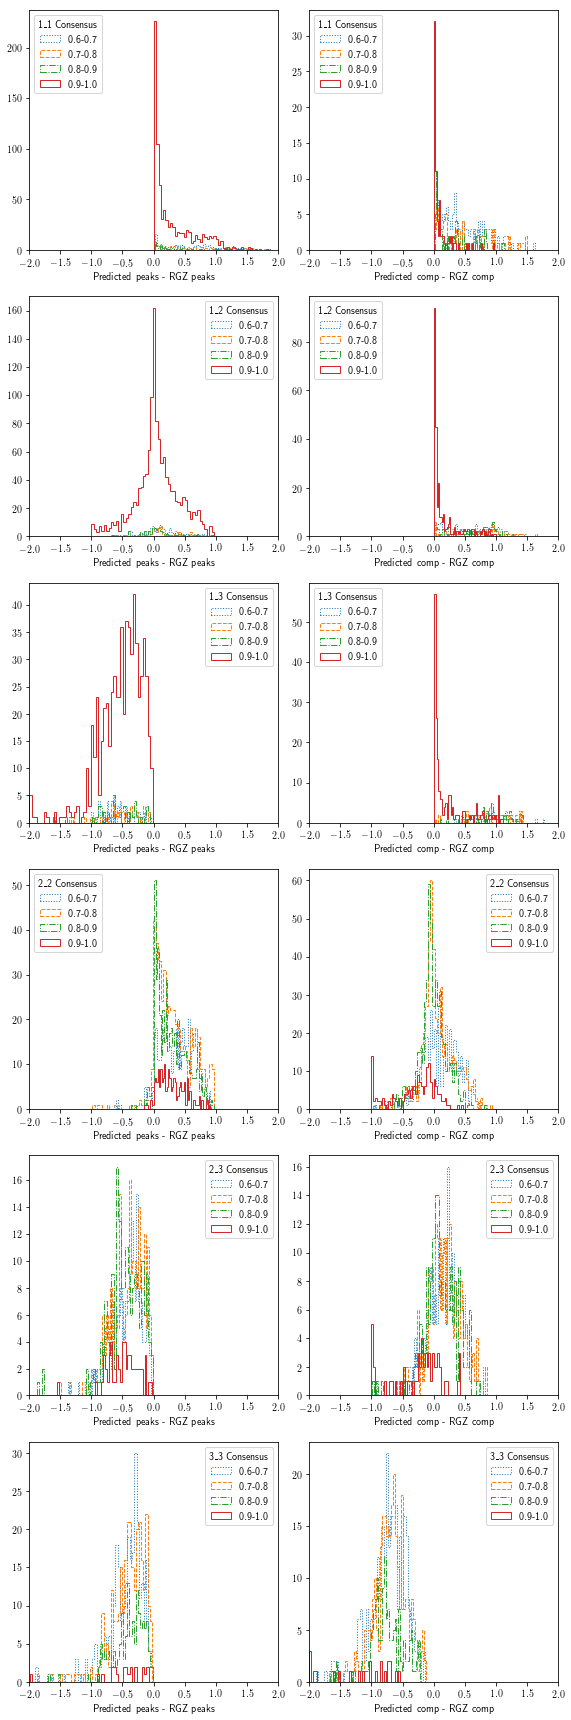

In [36]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    t_l = l.replace('_','\_')
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(val_peak!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{t_l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(val_comp!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{t_l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
# fig.show()
fig.savefig('Images/Figure_Label_Consensus_Histogram.pdf')

In [37]:
bin_df

array(['1_1', '1_2', '1_3', '2_2', '2_3', '3_3'], dtype=object)

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


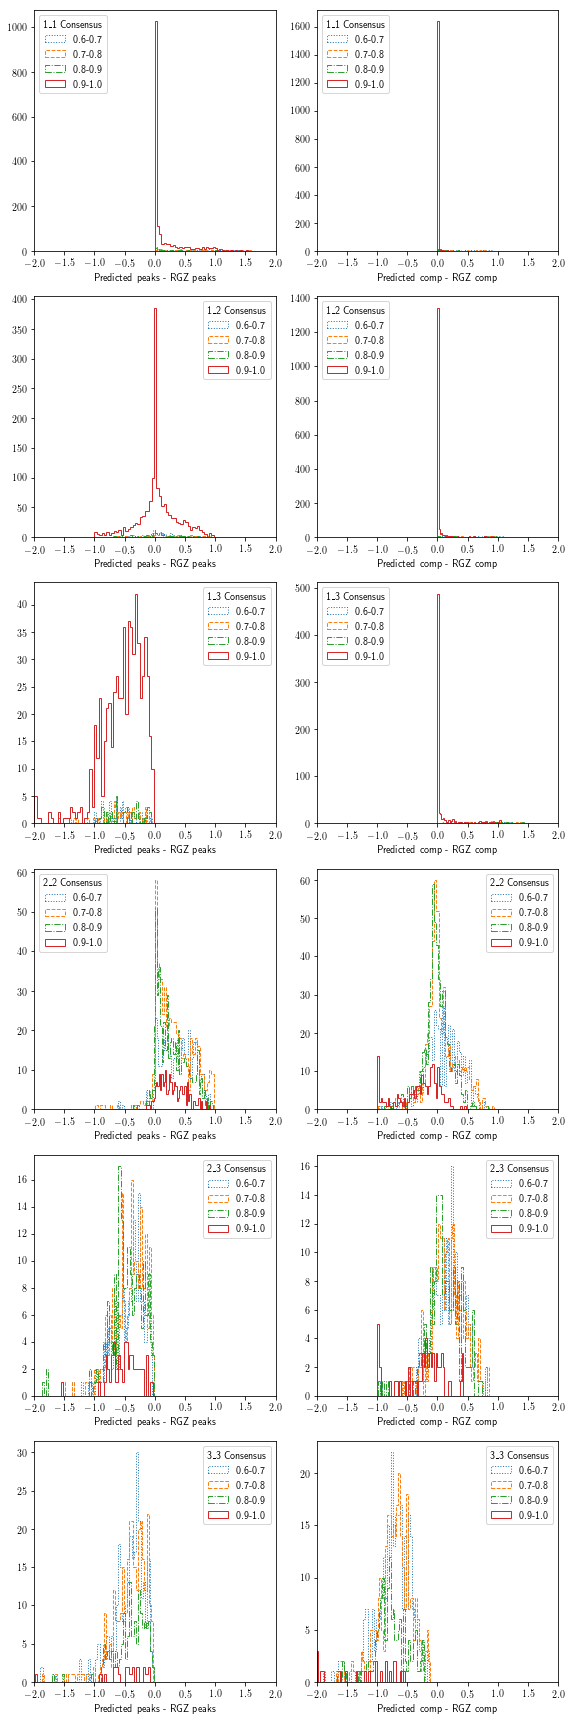

In [38]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    t_l = l.replace('_','\_')
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{t_l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{t_l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
fig.show()
# fig.savefig('Images/Figure_Label_Consensus_Histogram_With_Zero.pdf')

In [39]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':', '--']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 0.95, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-0.95', '0.95-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(val_peak!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(val_comp!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
fig.show()

RuntimeError: latex was not able to process the following string:
b'1_1 Consensus'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/gal16b/.matplotlib/tex.cache/7e37aa7bd56668e7b8738869bf632d96.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./7e37aa7bd56668e7b8738869bf632d96.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 \fontsize{10.000000}{12.500000}{\sffamily 1_
                                                 1 Consensus}
No pages of output.
Transcript written on 7e37aa7bd56668e7b8738869bf632d96.log.




Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x107cb6598> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'1_1 Consensus'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/gal16b/.matplotlib/tex.cache/7e37aa7bd56668e7b8738869bf632d96.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./7e37aa7bd56668e7b8738869bf632d96.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 \fontsize{10.000000}{12.500000}{\sffamily 1_
                                                 1 Consensus}
No pages of output.
Transcript written on 7e37aa7bd56668e7b8738869bf632d96.log.




RuntimeError: latex was not able to process the following string:
b'1_1 Consensus'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/gal16b/.matplotlib/tex.cache/7e37aa7bd56668e7b8738869bf632d96.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2017/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2017/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./7e37aa7bd56668e7b8738869bf632d96.aux)
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.13 \fontsize{10.000000}{12.500000}{\sffamily 1_
                                                 1 Consensus}
No pages of output.
Transcript written on 7e37aa7bd56668e7b8738869bf632d96.log.




<Figure size 576x1728 with 12 Axes>